[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/bayes_course_2023/blob/master/notebooks/Section3_2-Non_Parametric_Models.ipynb)

# Non-Parametric Models

## Spline Models

Often, the model we want to fit is not a perfect line between some $x$ and $y$.
Instead, the parameters of the model are expected to vary over $x$.
There are multiple ways to handle this situation, one of which is to fit a *spline*.
Spline fit is effectively a sum of multiple individual curves (piecewise polynomials), each fit to a different section of $x$, that are tied together at their boundaries, often called *knots*.

The spline is effectively multiple individual lines, each fit to a different section of $x$, that are tied together at their boundaries, often called *knots*.

Below is a full working example of how to fit a spline using PyMC. The data and model are taken from [*Statistical Rethinking* 2e](https://xcelab.net/rm/statistical-rethinking/) by Richard McElreath.


In [1]:
from pathlib import Path
import numpy as np
import scipy as sp
import pandas as pd 
import pymc as pm
from pymc.sampling_jax import sample_numpyro_nuts
import arviz as az
import seaborn as sns
import pytensor
import pytensor.tensor as pt
import matplotlib.pylab as plt
import matplotlib.cm as cmap
sns.set_context('notebook')

RANDOM_SEED = 42
DATA_URL = 'https://raw.githubusercontent.com/fonnesbeck/bayes_course_2023/master/data/'

from patsy import dmatrix

## Cherry blossom data

The data for this example is the number of days (`doy` for "days of year") that the cherry trees were in bloom in each year (`year`). 
For convenience, years missing a `doy` were dropped (which is a bad idea to deal with missing data in general!).

In [2]:
try:
    blossom_data = pd.read_csv(Path("..", "data", "cherry_blossoms.csv"), sep=";")
except FileNotFoundError:
    blossom_data = pd.read_csv(pm.get_data("cherry_blossoms.csv"), sep=";")


blossom_data.dropna().describe()

,year,doy,temp,temp_upper,temp_lower
count,787.000000,787.00000,787.000000,787.000000,787.000000
mean,1533.395172,104.92122,6.100356,6.937560,5.263545
std,291.122597,6.25773,0.683410,0.811986,0.762194
min,851.000000,86.00000,4.690000,5.450000,2.610000
25%,1318.000000,101.00000,5.625000,6.380000,4.770000
50%,1563.000000,105.00000,6.060000,6.800000,5.250000
75%,1778.500000,109.00000,6.460000,7.375000,5.650000
max,1980.000000,124.00000,8.300000,12.100000,7.740000


In [3]:
blossom_data = blossom_data.dropna(subset=["doy"]).reset_index(drop=True)
blossom_data.head(n=10)

,year,doy,temp,temp_upper,temp_lower
0,812,92.0,NaN,NaN,NaN
1,815,105.0,NaN,NaN,NaN
2,831,96.0,NaN,NaN,NaN
3,851,108.0,7.38,12.10,2.66
4,853,104.0,NaN,NaN,NaN
5,864,100.0,6.42,8.69,4.14
6,866,106.0,6.44,8.11,4.77
7,869,95.0,NaN,NaN,NaN
8,889,104.0,6.83,8.48,5.19
9,891,109.0,6.98,8.96,5.00


After dropping rows with missing data, there are 827 years with the numbers of days in which the trees were in bloom.

In [4]:
blossom_data.shape

(827, 5)

If we visualize the data, it is clear that there a lot of annual variation, but some evidence for a non-linear trend in bloom days over time.

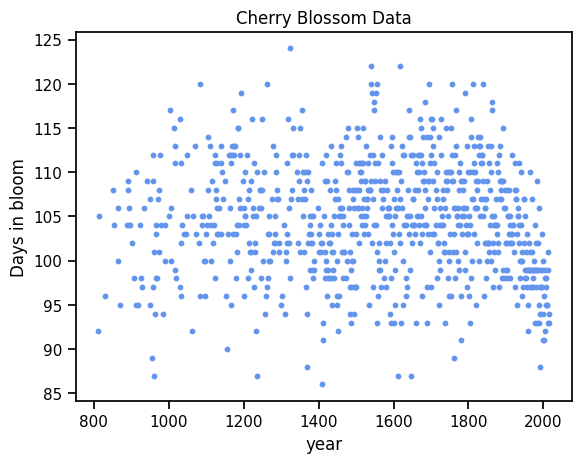

In [5]:
blossom_data.plot.scatter(
    "year", "doy", color="cornflowerblue", s=10, title="Cherry Blossom Data", ylabel="Days in bloom"
);

## The model

We will fit the following model.

$D \sim \mathcal{N}(\mu, \sigma)$  
$\quad \mu = a + Bw$  
$\qquad a \sim \mathcal{N}(100, 10)$  
$\qquad w \sim \mathcal{N}(0, 10)$  
$\quad \sigma \sim \text{Exp}(1)$

The number of days of bloom $D$ will be modeled as a normal distribution with mean $\mu$ and standard deviation $\sigma$. In turn, the mean will be a linear model composed of a y-intercept $a$ and spline defined by the basis $B$ multiplied by the model parameter $w$ with a variable for each region of the basis. Both have relatively weak normal priors.

### Prepare the spline

The spline will have 15 *knots*, splitting the year into 16 sections (including the regions covering the years before and after those in which we have data). The knots are the boundaries of the spline, the name owing to how the individual lines will be tied together at these boundaries to make a continuous and smooth curve.  The knots will be unevenly spaced over the years such that each region will have the same proportion of data.

In [6]:
num_knots = 15
knot_list = np.quantile(blossom_data.year, np.linspace(0, 1, num_knots))
knot_list

array([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583., 1650.,
       1714., 1774., 1833., 1893., 1956., 2015.])

Below is a plot of the locations of the knots over the data.

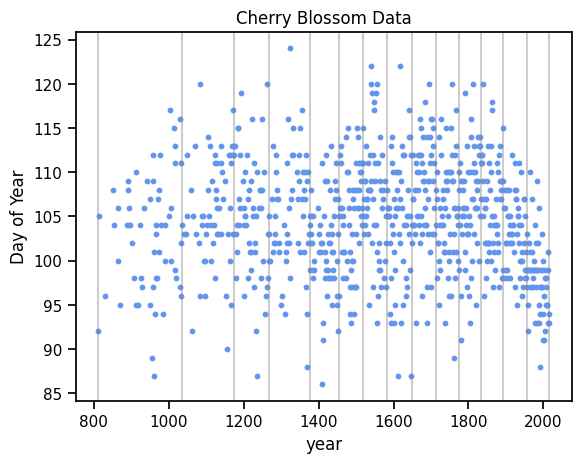

In [7]:
blossom_data.plot.scatter(
    "year", "doy", color="cornflowerblue", s=10, title="Cherry Blossom Data", ylabel="Day of Year"
)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

We can use `patsy` to create the matrix $B$ that will be the b-spline basis for the regression.
The degree is set to 3 to create a cubic b-spline.

In [8]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": blossom_data.year.values, "knots": knot_list[1:-1]},
)
B

DesignMatrix with shape (827, 17)
  Columns:
    ['bs(year, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[6]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[7]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[8]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[9]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[10]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[11]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[12]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[13]',
     'bs(year

The b-spline basis is plotted below, showing the *domain* of each piece of the spline. The height of each curve indicates how influential the corresponding model covariate (one per spline region) will be on model's inference of that region. The overlapping regions represent the knots, showing how the smooth transition from one region to the next is formed.

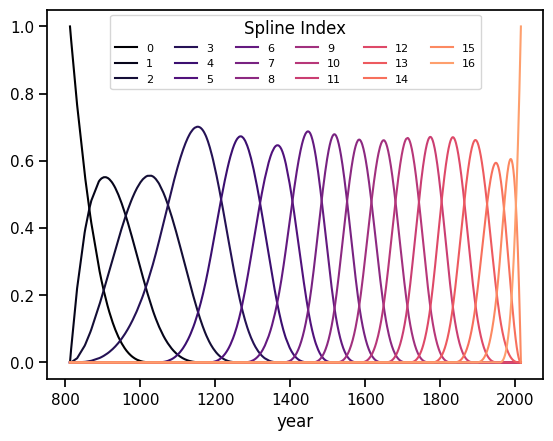

In [9]:
spline_df = (
    pd.DataFrame(B)
    .assign(year=blossom_data.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

color = plt.cm.magma(np.linspace(0, 0.80, len(spline_df.spline_i.unique())))

fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("year", "value", c=c, ax=plt.gca(), label=i)
plt.legend(title="Spline Index", loc="upper center", fontsize=8, ncol=6);

### Fit the model

Finally, the model can be built using PyMC. A graphical diagram shows the organization of the model parameters (note that this requires the installation of `python-graphviz`, which I recommend doing in a `conda` virtual environment).

In [10]:
COORDS = {"splines": np.arange(B.shape[1]),
          "obs": np.arange(blossom_data.shape[0])}
with pm.Model(coords=COORDS) as spline_model:
    
    a = pm.Normal("a", 100, 5)
    w = pm.Normal("w", mu=0, sigma=3, size=B.shape[1], dims="splines")
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=blossom_data.doy, dims="obs")

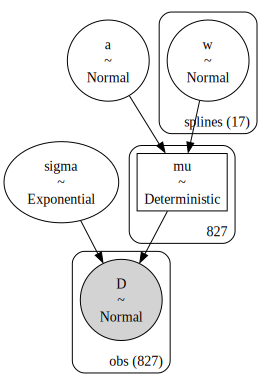

In [11]:
pm.model_to_graphviz(spline_model)

In [12]:
with spline_model:
    trace = pm.sample_prior_predictive()
    trace.extend(pm.sample(draws=1000, tune=1000, random_seed=RANDOM_SEED, chains=4))
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [D, a, sigma, w]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 115 seconds.
/Users/mate_scharnitzky/miniconda/envs/bayes_course/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


## Analysis

Now we can analyze the draws from the posterior of the model.

### Parameter Estimates

Below is a table summarizing the posterior distributions of the model parameters.
The posteriors of $a$ and $\sigma$ are quite narrow while those for $w$ are wider.
This is likely because all of the data points are used to estimate $a$ and $\sigma$ whereas only a subset are used for each value of $w$.
(It could be interesting to model these hierarchically allowing for the sharing of information and adding regularization across the spline.) 
The effective sample size and $\widehat{R}$ values all look good, indicating that the model has converged and sampled well from the posterior distribution.

In [13]:
az.summary(trace, var_names=["a", "w", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,103.641,0.757,102.218,105.032,0.018,0.013,1751.0,2044.0,1.0
w[0],-1.804,2.238,-5.864,2.455,0.034,0.028,4455.0,2991.0,1.0
w[1],-1.615,2.045,-5.300,2.357,0.034,0.025,3647.0,3233.0,1.0
w[2],-0.272,1.958,-3.886,3.418,0.034,0.030,3351.0,2881.0,1.0
w[3],3.330,1.486,0.528,6.043,0.029,0.020,2654.0,3086.0,1.0
w[4],0.201,1.488,-2.659,2.989,0.027,0.021,3145.0,2823.0,1.0
w[5],2.117,1.606,-0.837,5.177,0.028,0.020,3284.0,3472.0,1.0
w[6],-3.570,1.452,-6.072,-0.799,0.025,0.018,3407.0,3317.0,1.0
w[7],5.523,1.530,2.691,8.450,0.027,0.019,3137.0,2611.0,1.0
w[8],-0.054,1.540,-2.935,2.879,0.025,0.022,3751.0,3076.0,1.0


The trace plots of the model parameters look good (homogeneous and no sign of trend), further indicating that the chains converged and mixed.

/Users/mate_scharnitzky/miniconda/envs/bayes_course/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


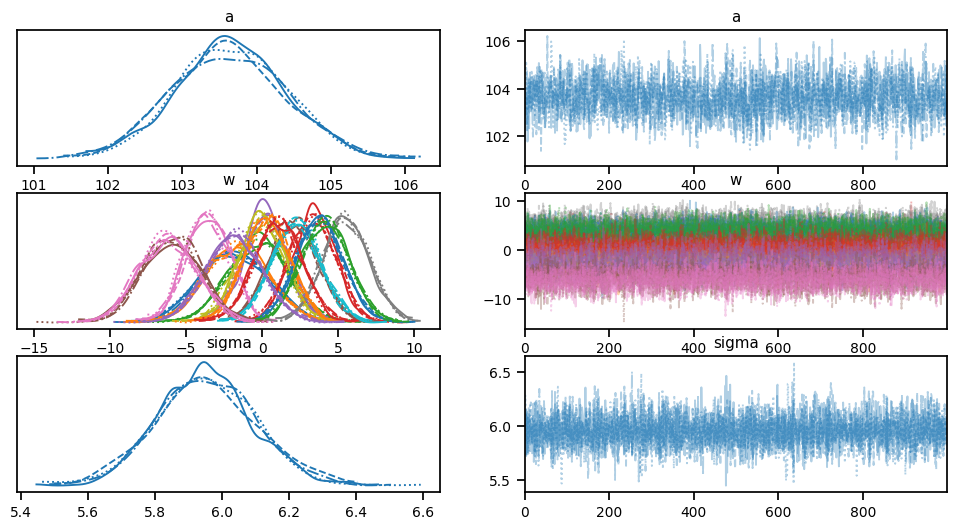

In [14]:
az.plot_trace(trace, var_names=["a", "w", "sigma"]);

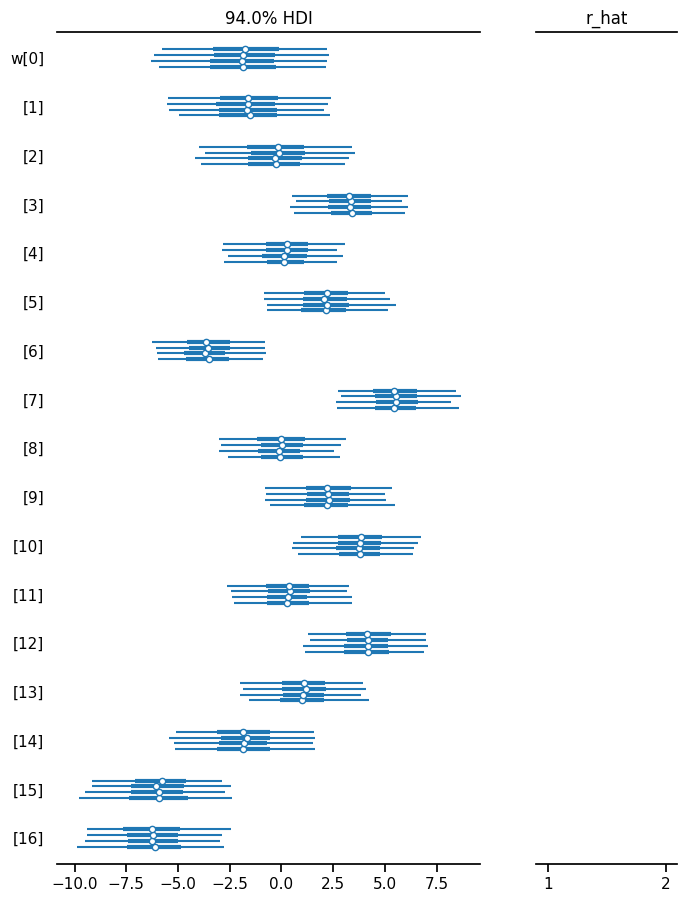

In [15]:
az.plot_forest(trace, var_names=["w"], r_hat=True);

Another visualization of the fit spline values is to plot them multiplied against the basis matrix.
The knot boundaries are shown as vertical lines again, but now the spline basis is multiplied against the values of $w$ (represented as the rainbow-colored curves). The dot product of $B$ and $w$ – the actual computation in the linear model – is shown in black.

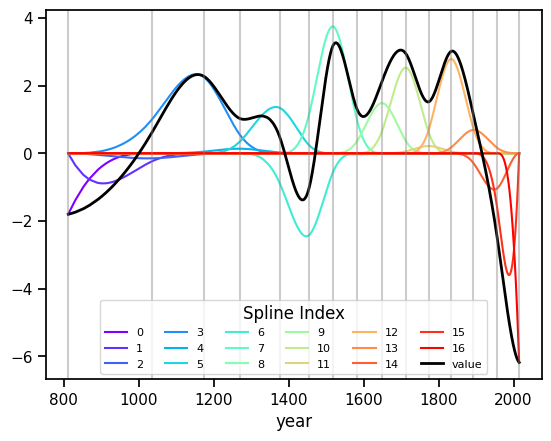

In [16]:
wp = trace.posterior["w"].mean(("chain", "draw")).values

spline_df = (
    pd.DataFrame(B * wp.T)
    .assign(year=blossom_data.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

spline_df_merged = (
    pd.DataFrame(np.dot(B, wp.T))
    .assign(year=blossom_data.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)


color = plt.cm.rainbow(np.linspace(0, 1, len(spline_df.spline_i.unique())))
fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("year", "value", c=c, ax=plt.gca(), label=i)
spline_df_merged.plot("year", "value", c="black", lw=2, ax=plt.gca())
plt.legend(title="Spline Index", loc="lower center", fontsize=8, ncol=6)

for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

### Model predictions

Lastly, we can visualize the predictions of the model using the posterior predictive check.

In [17]:
post_pred = az.summary(trace, var_names=["mu"]).reset_index(drop=True)
blossom_data_post = blossom_data.copy().reset_index(drop=True)
blossom_data_post["pred_mean"] = post_pred["mean"]
blossom_data_post["pred_hdi_lower"] = post_pred["hdi_3%"]
blossom_data_post["pred_hdi_upper"] = post_pred["hdi_97%"]

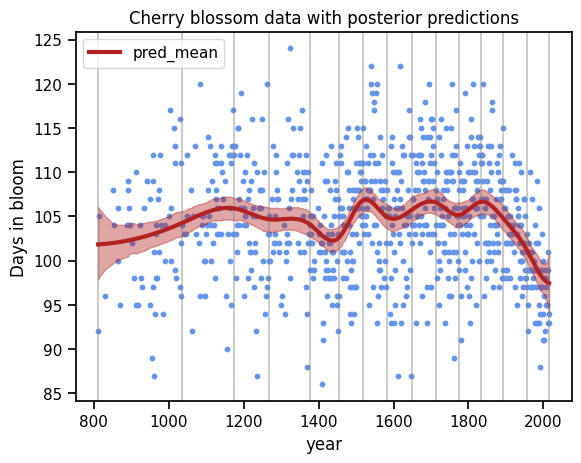

In [18]:
blossom_data.plot.scatter(
    "year",
    "doy",
    color="cornflowerblue",
    s=10,
    title="Cherry blossom data with posterior predictions",
    ylabel="Days in bloom",
)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4)

blossom_data_post.plot("year", "pred_mean", ax=plt.gca(), lw=3, color="firebrick")
plt.fill_between(
    blossom_data_post.year,
    blossom_data_post.pred_hdi_lower,
    blossom_data_post.pred_hdi_upper,
    color="firebrick",
    alpha=0.4,
);

## Gaussian Processes

Use of the term "non-parametric" in the context of Bayesian analysis is something of a misnomer. This is because the first and fundamental step in Bayesian modeling is to specify a *full probability model* for the problem at hand. It is rather difficult to explicitly state a full probability model without the use of probability functions, which are parametric. Bayesian non-parametric methods do not imply that there are no parameters, but rather that the number of parameters grows with the size of the dataset. In fact, Bayesian non-parametric models are *infinitely* parametric.

### Building models with Gaussians

What if we chose to use Gaussian distributions to model our data? 

$$p(x \mid \pi, \Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right\}$$

There would not seem to be an advantage to doing this, because normal distributions are not particularly flexible distributions in and of themselves. However, adopting a set of Gaussians (a multivariate normal vector) confers a number of advantages. First, the marginal distribution of any subset of elements from  a multivariate normal distribution is also normal:

$$p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu_x}  \\
  {\mu_y}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  {\Sigma_x} & {\Sigma_{xy}}  \\
  {\Sigma_{xy}^T} & {\Sigma_y}  \\
\end{array}
}\right]\right)$$

$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$

Also, conditionals distributions of a subset of a multivariate normal distribution (conditional on the remaining elements) are normal too:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$

A Gaussian process generalizes the multivariate normal to infinite dimension. It is defined as an infinite collection of random variables, any finite subset of which have a Gaussian distribution. Thus, the marginalization property is explicit in its definition. Another way of thinking about an infinite vector is as a *function*. When we write a function that takes continuous values as inputs, we are essentially specifying an infinte vector that only returns values (indexed by the inputs) when the function is called upon to do so. By the same token, this notion of an infinite-dimensional Gaussian as a function allows us to work with them computationally: we are never required to store all the elements of the Gaussian process, only to calculate them on demand.

So, we can describe a Gaussian process as a ***disribution over functions***. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a **mean function** and a **covariance function**:

$$p(x) \sim \mathcal{GP}(m(x), k(x,x^{\prime}))$$

It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed. 

For example, one specification of a GP might be as follows:

$$\begin{aligned}
m(x) &=0 \\
k(x,x^{\prime}) &= \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)
\end{aligned}$$

here, the covariance function is a **squared exponential**, for which values of $x$ and $x^{\prime}$ that are close together result in values of $k$ closer to 1 and those that are far apart return values closer to zero. 

In [19]:
def exponential_cov(x, y, scale, length_scale):
    return scale * np.exp( -0.5 * length_scale * np.subtract.outer(x, y)**2)

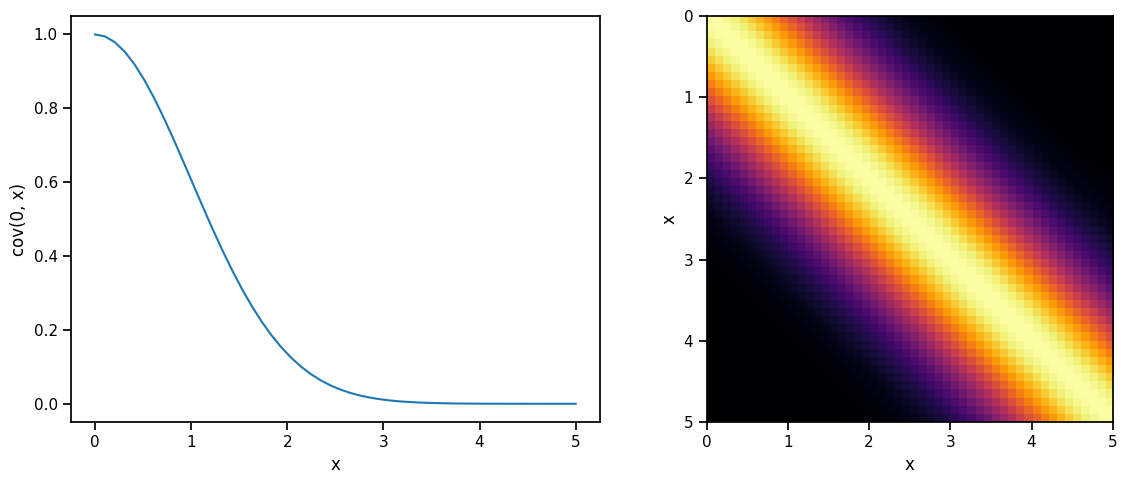

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
xrange = np.linspace(0, 5)
ax1.plot(xrange, exponential_cov(0, xrange, 1, 1))
ax1.set_xlabel('x')
ax1.set_ylabel('cov(0, x)')

z = np.array([exponential_cov(xrange, xprime, 1, 1) for xprime in xrange])
ax2.imshow(z, cmap="inferno", 
       interpolation='none', 
       extent=(0, 5, 5, 0))
ax2.set_xlabel('x')
ax2.set_ylabel('x')

plt.tight_layout();

It may seem odd to simply adopt the zero function to represent the mean function of the Gaussian process -- surely we can do better than that! It turns out that most of the learning in the GP involves the covariance function and its parameters, so very little is gained in specifying a complicated mean function.

For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean functon and covariance function evaluated at those points.

## Sampling from a Gaussian Process Prior

To make this notion of a "distribution over functions" more concrete, let's quickly demonstrate how we obtain realizations from a Gaussian process, which result in an evaluation of a function over a set of points. All we will do here is sample from the *prior* Gaussian process, so before any data have been introduced. What we need first is our covariance function, which will be the squared exponential, and a function to evaluate the covariance at given points (resulting in a covariance matrix).

We are going generate realizations sequentially, point by point, using the lovely conditioning property of mutlivariate Gaussian distributions. Here is that conditional:

$$p(y^*| x^*, y, x) = \mathcal{N}(\Sigma_{x^*x}\Sigma_y^{-1}y,\>
\Sigma_{x^*}-\Sigma_{x^*x}\Sigma_y^{-1}\Sigma_{x^*x}^T)$$

And this the function that implements it:

In [21]:
def conditional(x_new, x, y, scale, length_scale):
    B = exponential_cov(x_new, x, scale, length_scale)
    C = exponential_cov(x, x, scale, length_scale)
    A = exponential_cov(x_new, x_new, scale, length_scale)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

We will start with a Gaussian process prior with hyperparameters $\theta_0=1, \theta_1=10$. We will also assume a zero function as the mean, so we can plot a band that represents one standard deviation from the mean.

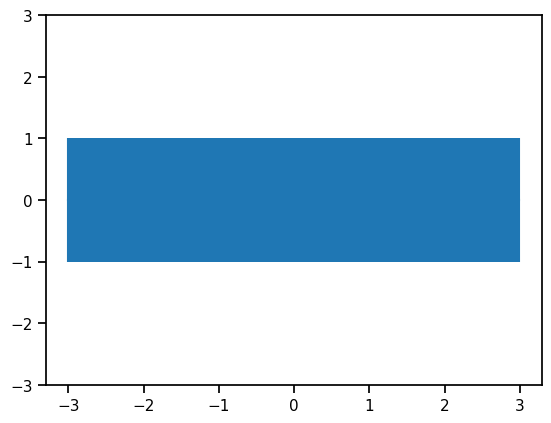

In [22]:
scale, length_scale = 1, 10
sigma_0 = exponential_cov(0, 0, scale, length_scale)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=sigma_0, capsize=0)
plt.ylim(-3, 3);

Let's select an arbitrary starting point to sample, say $x=1$. Since there are no prevous points, we can sample from an unconditional Gaussian:

In [23]:
x = [1.]
y = [np.random.normal(scale=sigma_0)]
y

[-1.3851110773940192]

We can now update our confidence band, given the point that we just sampled, using the covariance function to generate new point-wise intervals, conditional on the value $[x_0, y_0]$. 

In [24]:
sigma_1 = exponential_cov(x, x, scale, length_scale)

In [25]:
def predict(x, data, kernel, scale, length_scale, sigma, t):
    k = [kernel(x, y, scale, length_scale) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, scale, length_scale) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

In [26]:
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, scale, length_scale, sigma_1, y) for i in x_pred]

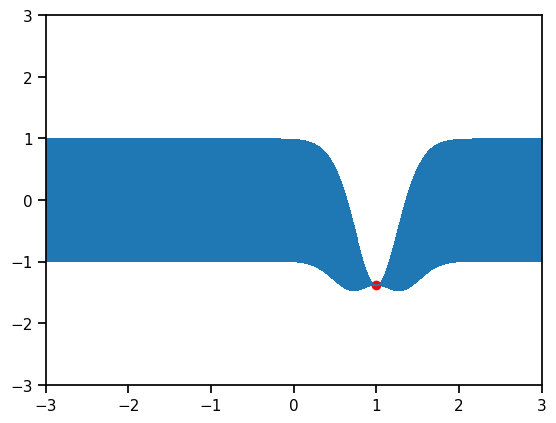

In [27]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3); plt.ylim(-3, 3);

So conditional on this point, and the covariance structure we have specified, we have essentially constrained the probable location of additional points. Let's now sample another:

In [28]:
m, s = conditional([-0.7], x, y, scale, length_scale)
y2 = np.random.normal(m, s)
y2

-1.6277696739008172

This point is added to the realization, and can be used to further update the location of the next point.

In [29]:
x.append(-0.7)
y.append(y2)

In [30]:
sigma_2 = exponential_cov(x, x, scale, length_scale)

predictions = [predict(i, x, exponential_cov, scale, length_scale, sigma_2, y) for i in x_pred]

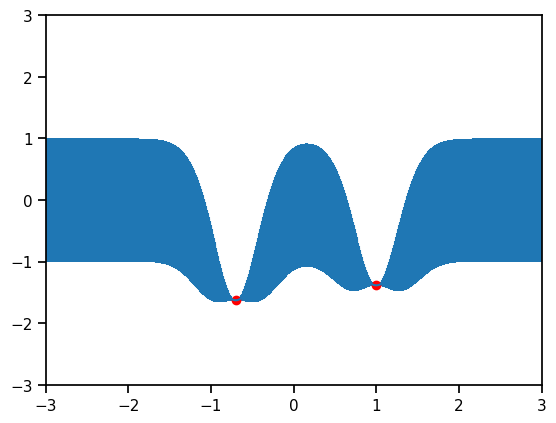

In [31]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3); plt.ylim(-3, 3);

Of course, sampling sequentially is just a heuristic to demonstrate how the covariance structure works. We can just as easily sample several points at once:

In [32]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, scale, length_scale)
y_more = np.random.multivariate_normal(mu, s)
y_more

array([ 0.68342566,  0.80127547, -0.03418792, -1.184001  , -1.04846999])

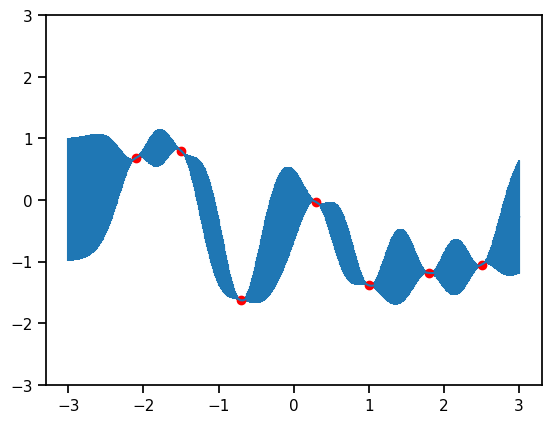

In [33]:
x += x_more
y += y_more.tolist()

sigma_new = exponential_cov(x, x, scale, length_scale)

predictions = [predict(i, x, exponential_cov, scale, length_scale, sigma_new, y) for i in x_pred]

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.ylim(-3, 3);

So as the density of points becomes high, the result will be one realization (function) from the prior GP. 

### Exercise

Generate a new draw from this GP, using a different set of points. (*HINT* just create new input values for `x` and and use them with `conditional`.)

Generate another draw, this time use a different set of hyperparameters: $\theta_0=1, \theta_1=1$. And another with $\theta_0=0.1, \theta_1=1$. How do the functions differ? What is the effect of the hyperparameters on the function space?

In [ ]:
# Write answer here
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]

This example, of course, is trivial because it is simply a random function drawn from the prior. What we are really interested in is *learning* about an underlying function from information residing in our data. In a parametric setting, we either specify a likelihood, which we then maximize with respect to the parameters, of a full probability model, for which we calculate the posterior in a Bayesian context. Though the integrals associated with posterior distributions are typically intractable for parametric models, they do not pose a problem with Gaussian processes.

## Gaussian processes regression

The following simulated data clearly shows some type of non-linear process, corrupted by a certain amount of observation or measurement error so it should be a reasonable task for a Gaussian process approach.

In [ ]:
# set the seed
np.random.seed(1)

n = 100 # The number of data points
x = np.linspace(0, 10, n)
X = x[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
l_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.Matern52(1, l_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC built on top of PyTensor
f_true = np.random.multivariate_normal(mean_func(X).eval(), 
    cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
sigma_true = 2.0
y = f_true + sigma_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

## Marginal Likelihood Implementation

The `gp.Marginal` class in PyMC implements the simplest case of GP regression:  the observed data are the sum of a GP and Gaussian noise.  `gp.Marginal` has a `marginal_likelihood` method, a `conditional` method, and a `predict` method.  Given a mean and covariance function, the function $f(x)$ is modeled as,

$$
f(x) \sim \mathcal{GP}(m(x),\, k(x, x')) \,.
$$

The observations $y$ are the unknown function plus noise

$$
\begin{aligned}
  \epsilon &\sim N(0, \Sigma) \\
  y &= f(x) + \epsilon \\
\end{aligned}
$$

### The Marginal Likelihood

The marginal likelihood is the normalizing constant for the posterior distribution, and is the integral of the product of the likelihood and prior.

$$p(y|X) = \int_f p(y|f,X)p(f|X) df$$

where for Gaussian processes, we are marginalizing over function values $f$ (instead of parameters $\theta$).

**GP prior**:

$$\log p(f|X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|K| -\frac{1}{2}f^TK^{-1}f $$

**Gaussian likelihood**:

$$\log p(y|f,X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|\sigma^2I| -\frac{1}{2}(y-f)^T(\sigma^2I)^{-1}(y-f) $$

**Marginal likelihood**:

$$\log p(y|X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|K + \sigma^2I| - \frac{1}{2}y^T(K+\sigma^2I)^{-1}y $$

Notice that the marginal likelihood includes both a data fit term $- \frac{1}{2}y^T(K+\sigma^2I)^{-1}y$ and a parameter penalty term $\frac{1}{2}\log|K + \sigma^2I|$. Hence, the marginal likelihood can help us select an appropriate covariance function, based on its fit to the dataset at hand.

### Choosing parameters

This is relevant because we have to make choices regarding the parameters of our Gaussian process; they were chosen arbitrarily for the random functions we demonstrated above.

For example, in the squared exponential covariance function, we must choose two parameters:

$$k(x,x^{\prime}) = \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)$$

The first parameter $\theta_1$ is a scale parameter, which allows the function to yield values outside of the unit interval. The second parameter $\theta_2$ is a length scale parameter that determines the degree of covariance between $x$ and $x^{\prime}$; smaller values will tend to smooth the function relative to larger values.

We can use the **marginal likelihood** to select appropriate values for these parameters, since it trades off model fit with model complexity. Thus, an optimization procedure can be used to select values for $\theta$ that maximize the marginial likelihood.

### Covariance functions

The behavior of individual realizations from the GP is governed by the covariance function. This function controls both the degree of *shrinkage* to the mean function and the *smoothness* of functions sampled from the GP.

PyMC includes a library of covariance functions to choose from. A flexible choice to start with is the Mat&#232;rn covariance. 

$$k_{M}(x) = \frac{\sigma^2}{\Gamma(\nu)2^{\nu-1}} \left(\frac{\sqrt{2 \nu} x}{l}\right)^{\nu} K_{\nu}\left(\frac{\sqrt{2 \nu} x}{l}\right)$$

where where $\Gamma$ is the gamma function and $K$ is a modified Bessel function. The form of covariance matrices sampled from this function is governed by three parameters, each of which controls a property of the covariance.

* **amplitude** ($\sigma$) controls the scaling of the output along the y-axis. This parameter is just a scalar multiplier, and is therefore usually left out of implementations of the Mat&#232;rn function (*i.e.* set to one)

* **lengthscale** ($l$) complements the amplitude by scaling realizations on the x-axis. Larger values make points appear closer together.

* **roughness** ($\nu$) controls the sharpness of ridges in the covariance function, which ultimately affect the roughness (smoothness) of realizations.

Though in general all the parameters are non-negative real-valued, when $\nu = p + 1/2$ for integer-valued $p$, the function can be expressed partly as a polynomial function of order $p$ and generates realizations that are $p$-times differentiable, so values $\nu \in \{3/2, 5/2\}$ are extremely common.

To provide an idea regarding the variety of forms or covariance functions, here's small selection of available ones:

In [ ]:
X = np.linspace(0,2,200)[:,None]

# function to display covariance matrices
def plot_cov(X, K, stationary=True):
    K = K + 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    
    with sns.axes_style("white"):

        fig = plt.figure(figsize=(14,5))
        ax1 = fig.add_subplot(121)
        m = ax1.imshow(K, cmap="inferno", 
                       interpolation='none', 
                       extent=(np.min(X), np.max(X), np.max(X), np.min(X))); 
        plt.colorbar(m);
        ax1.set_title("Covariance Matrix")
        ax1.set_xlabel("X")
        ax1.set_ylabel("X")

        ax2 = fig.add_subplot(122)
        if not stationary:
            ax2.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
            ax2.set_title("The Diagonal of K")
            ax2.set_ylabel("k(x,x)")
        else:
            ax2.plot(x, K[:,0], "k", lw=2, alpha=0.8)
            ax2.set_title("K as a function of x - x'")
            ax2.set_ylabel("k(x,x')")
        ax2.set_xlabel("X")

        fig = plt.figure(figsize=(14,4))
        ax = fig.add_subplot(111)
        samples = np.random.multivariate_normal(np.zeros(200), K, 5).T;
        for i in range(samples.shape[1]):
            ax.plot(x, samples[:,i], color=cmap.inferno(i*0.2), lw=2);
        ax.set_title("Samples from GP Prior")
        ax.set_xlabel("X")

### Quadratic exponential covariance

This is the squared exponential covariance function.

In [ ]:
with pm.Model() as model:
    l = 0.2 
    tau = 2.0
    b = 0.5
    cov = b + tau * pm.gp.cov.ExpQuad(1, l)

K = pytensor.function([], cov(X))()

plot_cov(X, K)

### Matern $\nu=3/2$ covariance

In [ ]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Matern32(1, l)

K = pytensor.function([], cov(X))()

plot_cov(X, K)

### Cosine covariance

In [ ]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Cosine(1, l)

K = pytensor.function([], cov(X))()

plot_cov(X, K)

## Exercise: Combining Kernels

Modeling with a single kernel is useful if your data is all the same type, but what if you have multiple types of features, but you still want to model them together? 

It turns out that we can build a kernel over different datatypes by multiplying or adding kernels together.

Choose a couple of kernels from above and create a covariance function that multiplies them together. Plot the result with `plot_cov`.

In [ ]:
# Write your answer here

Compare this to the result when the kernels are added instead of multiplied.

In [ ]:
# Write your answer here

Now that we have a general idea about covariance functions, let's begin by defining one for our first model.

We can use a Matern(5/2) covariance to model our simulated data, and pass this as the `cov_func` argument to the `Marginal` class.

In [ ]:
with pm.Model() as model:
    
    l = pm.Gamma("l", alpha=2, beta=1)
    eta = pm.HalfCauchy("eta", beta=5)
    
    cov = eta**2 * pm.gp.cov.Matern52(1, l)
    mean = pm.gp.mean.Constant(c=1)
    gp = pm.gp.Marginal(mean_func=mean, cov_func=cov)

### The `.marginal_likelihood` method

The unknown latent function can be analytically integrated out of the product of the GP prior probability with a normal likelihood.  This quantity is called the marginal likelihood. 

$$
p(y \mid x) = \int p(y \mid f, x) \, p(f \mid x) \, df
$$

The log of the marginal likelihood, $p(y \mid x)$, is

$$
\log p(y \mid x) = 
  -\frac{1}{2} (\mathbf{y} - \mathbf{m}_x)^{T} 
               (\mathbf{K}_{xx} + \boldsymbol\Sigma)^{-1} 
               (\mathbf{y} - \mathbf{m}_x)
  - \frac{1}{2}|\mathbf{K}_{xx} + \boldsymbol\Sigma|
  - \frac{n}{2}\log (2 \pi)
$$

$\boldsymbol\Sigma$ is the covariance matrix of the Gaussian noise.  Since the Gaussian noise doesn't need to be white to be conjugate, the `marginal_likelihood` method supports either using a white noise term when a scalar is provided, or a noise covariance function when a covariance function is provided.

The `gp.marginal_likelihood` method implements the quantity given above.

In [ ]:
X = x.reshape(-1, 1)

with model:
    
    sigma = pm.HalfCauchy("sigma", beta=5)
    obs = gp.marginal_likelihood("obs", X=X, y=y, sigma=sigma)

In [ ]:
with model:
    marginal_post = pm.sample(500, tune=2000, nuts_sampler='numpyro', chains=1)

We can collect the results into a pandas dataframe to display

In [ ]:
summary = az.summary(marginal_post, var_names=["l", "eta", "sigma"], round_to=2, kind="stats")
summary["True value"] = [l_true, eta_true, sigma_true]
summary

### The `.conditional` distribution

In addition to fitting the model, we would like to be able to generate predictions. This implies sampling from the posterior predictive distribution, which if you recall is just some linear algebra:

$$\begin{aligned}
m^*(x^*) &= k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}y \\
k^*(x^*) &= k(x^*,x^*)+\sigma^2 - k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}k(x^*,x)
\end{aligned}$$

PyMC allows for predictive sampling after the model is fit, using the recorded values of the model parameters to generate samples. The `conditional` method implements the predictive GP above, called with a grid of points over which to generate realizations:

The `.conditional` has an optional flag for `pred_noise`, which defaults to `False`.  When `pred_noise=False`, the `conditional` method produces the predictive distribution for the underlying function represented by the GP.  When `pred_noise=True`, the `conditional` method produces the predictive distribution for the GP plus noise.  

If using an additive GP model, the conditional distribution for individual components can be constructed by setting the optional argument `given`.  

We can define a grid of new values from `x=0` to `x=20`, then add the GP conditional to the model, given the new X values:



In [ ]:
X_new = np.linspace(0, 20, 600)[:,None]

with model:
    f_pred = gp.conditional("f_pred", X_new)

We can draw samples from the posterior predictive distribution over the specified grid of values.

In [ ]:
with model:
    pred_samples = pm.sample_posterior_predictive(marginal_post.sel(draw=slice(0, 20)), var_names=['f_pred'])

In [ ]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist
f_pred_samples = az.extract(pred_samples, group="posterior_predictive", var_names=["f_pred"])
plot_gp_dist(ax, samples=f_pred_samples.T, x=X_new);

# plot the data and the true latent function
plt.plot(x, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(x, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

The prediction also matches the results from `gp.Latent` very closely.  What about predicting new data points?  Here we only predicted $f_*$, not $f_*$ + noise, which is what we actually observe.

The `conditional` method of `gp.Marginal` contains the flag `pred_noise` whose default value is `False`.  To draw from the *posterior predictive* distribution, we simply set this flag to `True`. 

In [ ]:
with model:
    y_pred = gp.conditional("y_pred", X_new, pred_noise=True)
    y_samples = pm.sample_posterior_predictive(marginal_post.sel(draw=slice(0, 20)), var_names=['y_pred'])

In [ ]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# posterior predictive distribution
y_pred_samples = az.extract(y_samples, group="posterior_predictive", var_names=["y_pred"])
plot_gp_dist(ax, y_pred_samples.T, X_new, plot_samples=False, palette="bone_r");

# overlay a scatter of one draw of random points from the 
#   posterior predictive distribution
plt.plot(X_new, y_pred_samples.values.T[0], "co", ms=2, label="Predicted data");

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f");

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("posterior predictive distribution, y_*"); plt.legend();

### Real-world example: Spawning salmon

That was contrived data; let's try applying Gaussian processes to a real problem. The plot below shows the relationship between the number of spawning salmon in a particular stream and the number of fry that are recruited into the population in the spring.

We would like to model this relationship, which appears to be non-linear (we have biological knowledge that suggests it should be non-linear too).

![](images/spawn.jpg)

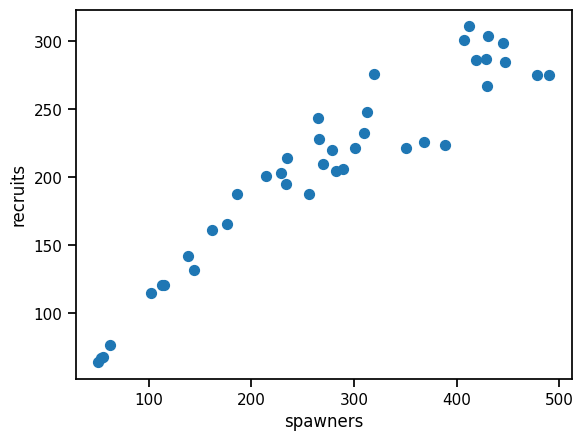

In [34]:
try:
    salmon_data = pd.read_table('../data/salmon.txt', sep='\s+', index_col=0)
except FileNotFoundError:
    salmon_data = pd.read_table(DATA_URL + 'salmon.txt', sep='\s+', index_col=0)
    
salmon_data.plot.scatter(x='spawners', y='recruits', s=50);

In [36]:
with pm.Model() as salmon_model:

    # Lengthscale
    rho = pm.LogNormal('rho', 0, 1)
    eta = pm.LogNormal('eta', 0, 1)
    
    M = pm.gp.mean.Linear(coeffs=(salmon_data.recruits/salmon_data.spawners).mean())
    K = (eta**2) * pm.gp.cov.ExpQuad(1, rho) 
    
    sigma = pm.HalfNormal('sigma', 5)
    
    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    recruit_gp.marginal_likelihood('recruits', X=salmon_data.spawners.values.reshape(-1,1), y=salmon_data.recruits.values, noise=sigma)
    

/Users/mate_scharnitzky/miniconda/envs/bayes_course/lib/python3.11/site-packages/pymc/gp/gp.py:54: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [37]:
with salmon_model:
    salmon_trace = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, eta, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 294 seconds.


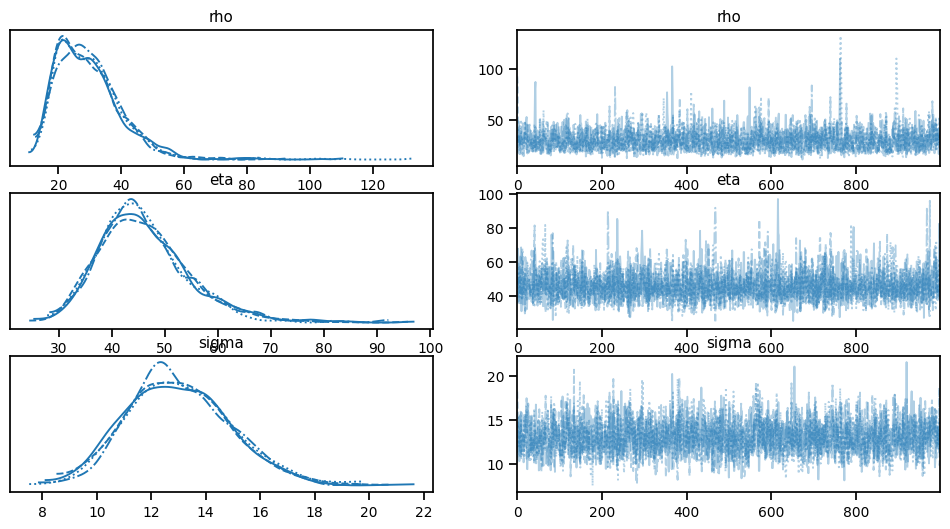

In [38]:
az.plot_trace(salmon_trace, var_names=['rho', 'eta', 'sigma']);

In [39]:
X_pred = np.linspace(0, 500, 100).reshape(-1, 1)
with salmon_model:
    salmon_pred = recruit_gp.conditional("salmon_pred", X_pred)
    salmon_samples = pm.sample_posterior_predictive(salmon_trace.sel(draw=slice(0, 5)), var_names=["salmon_pred"])

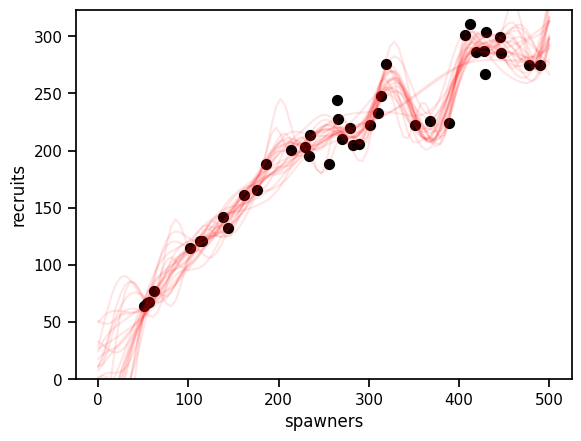

In [40]:
ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for x in az.extract(salmon_samples.posterior_predictive)['salmon_pred'].values.T:
    ax.plot(X_pred, x, alpha=0.1, c='r');

### Exercise

We might be interested in what may happen if the population gets very large -- say, 600 or 800 spawners. We can predict this, though it goes well outside the range of data that we have observed. Generate predictions from the posterior predictive distribution (via `conditional`) that covers this range of spawners.

In [ ]:
# Write answer here

### Using `.predict`

We can use the `.predict` method to return the mean and variance given a particular `point`.  Since we used `find_MAP` in this example, `predict` returns the same mean and covariance that the distribution of `.conditional` has.  

In [ ]:
# predict
with model:
    mu, var = gp.predict(X_new, point=az.extract(marginal_post.posterior.sel(draw=[0])).squeeze(), diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2sigma intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2sigma region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f");

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("predictive mean and 2sigma interval"); plt.legend();

## Latent Variable Implementation

The `gp.Latent` class is a more general implementation of a GP.  It is called "Latent" because the underlying function values are treated as latent variables.  It has a `prior` method, and a `conditional` method.  Given a mean and covariance function, the function $f(x)$ is modeled as,

$$
f(x) \sim \mathcal{GP}(m(x),\, k(x, x')) \,.
$$

## `.prior`

With some data set of finite size, the `prior` method places a multivariate normal prior distribution on the vector of function values, $\mathbf{f}$,

$$
\mathbf{f} \sim \text{MvNormal}(\mathbf{m}_{x},\, \mathbf{K}_{xx}) \,,
$$

where the vector $\mathbf{m}$ and the matrix $\mathbf{K}_{xx}$ are the mean vector and covariance matrix evaluated over the inputs $x$.  

By default, PyMC reparameterizes the prior on `f` under the hood by rotating it with the Cholesky factor of its covariance matrix.  This helps to reduce covariances in the posterior of the transformed random variable, `v`.  The reparameterized model is,

$$
\begin{aligned}
  \mathbf{v} \sim \text{N}(0, 1)& \\
  \mathbf{L} = \text{Cholesky}(\mathbf{K}_{xx})& \\
  \mathbf{f} = \mathbf{m}_{x} + \mathbf{Lv} \\
\end{aligned}
$$

This reparameterization can be disabled by setting the optional flag in the `prior` method, `reparameterize = False`.  The default is `True`.

## Robust regession

The following is an example showing how to specify a simple model with a GP prior using the `gp.Latent` class.  So we can verify that the inference we perform is correct, the data set is made using a draw from a GP.  This will be identical to the first example, except that the noise is Student-T distributed.

In [ ]:
# set the seed
np.random.seed(1)

n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ls_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.Matern52(1, ls_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC built on top of PyTensor
f_true = np.random.multivariate_normal(mean_func(X).eval(), 
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
sigma_true = 2.0
nu_true = 3.0
y = f_true + sigma_true * np.random.standard_t(nu_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

Here's the model in PyMC.  We use a $\text{Gamma}(2, 1)$ prior over the lengthscale parameter, and weakly informative $\text{HalfCauchy}(2)$ priors over the covariance function scale, and noise scale.  A $\text{Gamma}(2, 0.1)$ prior is assigned to the degrees of freedom parameter of the noise.  Finally, a GP prior is placed on the unknown function.  

In [ ]:
with pm.Model() as model:
    ls = pm.Gamma("ls", alpha=2, beta=1)
    eta = pm.HalfCauchy("eta", beta=2)
    
    cov = eta**2 * pm.gp.cov.Matern52(1, ls)
    gp = pm.gp.Latent(cov_func=cov)
    
    f = gp.prior("f", X=X)
    
    sigma = pm.HalfCauchy("sigma", beta=2)
    nu = pm.Gamma("nu", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0/sigma, nu=nu, observed=y)
    
    trace = pm.sample(nuts_sampler='numpyro', chains=2)

Below are the posteriors of the covariance function hyperparameters. 

In [ ]:
az.plot_trace(trace, var_names=["eta", "sigma", "ls", "nu"], backend_kwargs=dict(constrained_layout=True));

In [ ]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist
plot_gp_dist(ax, trace.posterior["f"].values[0], X);

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)"); 
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

## Faster Gaussian processes

One of the major constraints that limits the utility of Gaussian processes in practice is the inversion of $K$ when calculating the posterior covariance. Since it is evaluated at every observed data point, its execution time is $\mathcal{O(n^3)}$, which makes Gaussian processes (in the form I have presented here) impractical for larger datasets.

An approach for dealing with this computation complexity is to look for an approximation to accelerate training and prediction. For Gaussian processes, this can be accomplished by employing a **sparse approximation** to the Gram matrix that places $M<<N$ *inducing points* along the range of the input variables, and uses this to estimate the full covariance matrix for the observed points. 

The `gp.MarginalSparse` class implements sparse, or inducing point, GP approximations.  It works identically to `gp.Marginal`, except it additionally requires the locations of the inducing points (denoted `Xu`), and it accepts the argument `sigma` instead of `noise` because these sparse approximations assume white IID noise.

The downside of sparse approximations is that they reduce the expressiveness of the GP.  Reducing the dimension of the covariance matrix effectively reduces the number of covariance matrix eigenvectors that can be used to fit the data.  

A choice that needs to be made is where to place the inducing points.  One option is to use a subset of the inputs.  Another possibility is to use K-means.  The location of the inducing points can also be an unknown and optimized as part of the model.  These sparse approximations are useful for speeding up calculations when the density of data points is high and the lengthscales is larger than the separations between inducing points. 

### Dense dataset

For the following examples, we use the same data set as was used in the `gp.Marginal` example, but with more data points.

In [ ]:
# set the seed
np.random.seed(42)

n = 2000 # The number of data points
X = 10*np.sort(np.random.rand(n))[:,None]

# Define the true covariance function and its parameters
ls_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.Matern52(1, ls_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC built on top of PyTensor
f_true = np.random.multivariate_normal(mean_func(X).eval(), 
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
sigma_true = 2.0
y = f_true + sigma_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("The true f(x)"); plt.legend();

We can specify a sparse marginal likelihood model via `MarginalSparse`, where the approximation method can be chosen. We will use the **fully independent training conditional (FITC)** algorithm to estimate the model, with the critical approximation being the imposition of a conditional independence assumption on the joint prior over training and test cases.

In [ ]:
with pm.Model() as sparse_model:
    
    ls = pm.Gamma("ls", alpha=2, beta=1)
    eta = pm.HalfCauchy("eta", beta=5)
    
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls)
    gp = pm.gp.MarginalApprox(cov_func=cov, approx="FITC")

We next need a set of inducing points. We will initialize 20 inducing points with the **K-means** algorithm.

In [ ]:
with sparse_model:
    
    Xu = pm.gp.util.kmeans_inducing_points(20, X)

From here, we use the `marginal_likelihood` method, just as we did with the full GP.

In [ ]:
with sparse_model:
    
    sigma = pm.HalfCauchy("sigma", 5)
    obs = gp.marginal_likelihood("obs", X=X, Xu=Xu, y=y, noise=sigma, jitter=1e-5)
    
    trace = pm.sample(nuts_sampler='numpyro', chains=1)


In [ ]:
az.plot_trace(trace, var_names=["eta", "ls"], backend_kwargs=dict(constrained_layout=True));

In [ ]:
X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with sparse_model:
    f_pred = gp.conditional("f_pred", X_new)

In [ ]:
with sparse_model:
    pred_samples = pm.sample_posterior_predictive(trace.sel(draw=slice(0, 5)), var_names=["f_pred"])

In [ ]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist
f_pred_samples = az.extract(pred_samples, group="posterior_predictive", var_names=["f_pred"])
plot_gp_dist(ax, f_pred_samples.T, X_new);

# plot the data and the true latent function
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "co", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

# HSGP

HSGP is a drop in replacement for `pm.gp.Latent`, or the vanilla GP.  There isn't a need to fuss with marginalizing it out, not sampling the GP directly and trying to get it back later.  The only thing we need to choose are `m` and `c` (or `L`).  `m` controls the number of basis vectors to use, and `c` or `L` control the boundary where the approximation is accurate.  You can read `c` as the multiple on the half range of the data over which the approximation is accurate.  For instance, if your `x` data goes between -5 and 5, and you want the GP approximation to be accurate from -10 to 10, you'll need to choose `c` to be *at least* 2.

Some rules of thumb are:

- Larger `m` means we can use smaller lengthscales (more wiggly)
- Larger `c` means we can use larger lengthscales

In [Ruitort-Mayol et. al.'s paper](https://arxiv.org/pdf/2004.11408.pdf), they give some recommendations for choosing `m` and `c` that we can plot below.  

#### Cherry blossom data set

Let's look at the cherry blossom dataset again, notably three columns: 
- `doy` the day of year of the first bloom
- `temp` the temperature (since it goes so far back in time, I'm not sure how it's reconstructed)
- `year` is of course the year

In [ ]:
df = pd.read_csv(pm.get_data("cherry_blossoms.csv"), sep=";")
df = df[["year", "doy", "temp"]].dropna()

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7)); axs = axs.flatten()

axs[0].scatter(df["year"], df["temp"])
axs[1].scatter(df["year"], df["doy"])

axs[1].set_xlabel("year")
axs[0].set_ylabel("temp (C)")
axs[1].set_ylabel("day of the first bloom")
fig.tight_layout()

In [ ]:
from matplotlib.ticker import MultipleLocator

c_list = np.array([1.2, 1.3, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0])
ell = np.linspace(1, 1000, 500)
S = (df["year"] - df["year"].mean()).max() # half-range of the input data

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()

cmap = plt.cm.cividis
colors = np.arange(len(c_list)) / len(c_list)

for i, c in enumerate(c_list):
    m = 2.65 * (c / ell) * S
   
    ix = c >= (4.1 * (ell / S))
    m[~ix] = np.nan
    ax.semilogy(ell, m, color=cmap(colors[i]), label="c = %s" % str(c), lw=3);

ax.grid(True);

ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(10))

ax.set_title("Matern52 HSGP approx parameter curves");
ax.set_ylim([10, 1000]);
ax.set_xlabel("lengthscale (ℓ)");
ax.set_ylabel("number of basis vectors (m)");
ax.legend();

The curves show the regions where the HSGP approximation is accurate.  For instance, the darkest blue line at $c=1.2$ means that if we choose $c=1.2$, our approximation will be valid for the smallest lengthscales up until about $\ell = 130$.  The yellow curve at $c=6.0$ means shows that the approximation is accurate up until about $\ell = 650$.  **How we choose these values depends on our prior for the lengthscale**.  In our case we are setting 95% of the prior mass between 20 and 200.  We'll be safe and choose $c=2$ and $m=400$ so our prior range is well covered pretty well.  

Also, keep in mind that HSGP scales as $\mathcal{O}(nm + m)$, so the smaller we can choose $m$, the better, speed-wise.  $c$ plays no role in computation speed.

In [ ]:
coords = {
    "year": df.year.tolist()
}
with pm.Model(coords=coords) as model:
    # Set prior on GP hyperparameters
    eta = pm.Exponential("eta", lam=0.25)
    
    ell_params = pm.find_constrained_prior(
        pm.InverseGamma, 
        lower=20, upper=200, 
        init_guess={"alpha": 2, "beta": 20},
        mass=0.95,
    )
    ell = pm.InverseGamma("ell", **ell_params)
    
    # Specify covariance function and GP
    cov = eta**2 * pm.gp.cov.Matern52(1, ls=ell)
    gp = pm.gp.HSGP(m=[400], c=2.0, cov_func=cov)
    f = gp.prior("f", X=df["year"].values[:, None], dims="year")
    
    intercept = pm.Normal("intercept", mu=df["temp"].mean(), sigma=2 * df["temp"].std())
    mu = pm.Deterministic("mu", intercept + f, dims="year")
    
    sigma = pm.HalfNormal("sigma", sigma=2 * df["temp"].std())
    pm.Normal("y", mu=mu, sigma=sigma, observed=df["temp"].values)

In [ ]:
with model:
    trace_gp = pm.sample(nuts_sampler='numpyro', chains=2)

In [ ]:
az.plot_trace(trace_gp, var_names=["eta", "ell", "sigma", "intercept"]);

This took a few minutes on my machine.  It's definitely slower than the spline models, but we obtained results that look much better.  Compare to when we used a spline with 400 knots.  NUTs depends a ton on the posterior geometry, and sampling the GP hyperparameters has a huge influence, but the speeds are still comparable.  We also see a lengthscale of about 40, which we can interpret as meaning that it takes about 40 years for significant changes in temperature to occur.  We can also interpret this to roughly mean that the GP is comfortable predicting out about 40 years.  

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10));

f = az.extract(trace_gp, group="posterior", var_names="mu")
pm.gp.util.plot_gp_dist(ax=ax, samples=f.values.T, x=df["year"].values)
ax.plot(df["year"].values, df["temp"].values, "ok", alpha=0.25);


## Example: Nashville daily temperatures

The file `TNNASHVI.txt` in your data directory contains daily temperature readings for Nashville, courtesy of the [Average Daily Temperature Archive](http://academic.udayton.edu/kissock/http/Weather/). This data, as one would expect, oscillates annually. Use a Gaussian process to fit a regression model to this data.

In [43]:
daily_temps = pd.read_table("../data/TNNASHVI.txt", sep='\s+', 
                            names=['month','day','year','temp'], na_values=-99)
daily_temps.head()

,month,day,year,temp
0,1,1,1995,46.7
1,1,2,1995,28.7
2,1,3,1995,27.9
3,1,4,1995,27.0
4,1,5,1995,18.5


<Axes: >

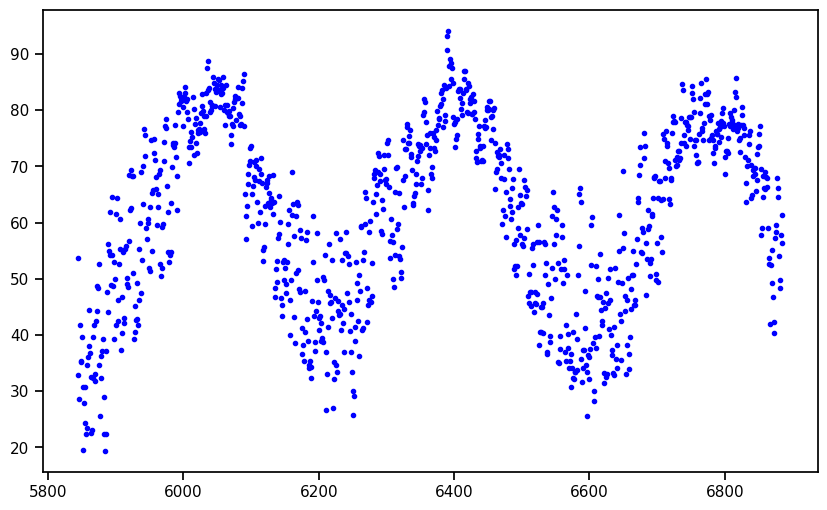

In [45]:
temps_2010 = daily_temps.temp[daily_temps.year>2010]
temps_2010.plot(style='b.', figsize=(10,6), grid=False)

In [46]:
x, y = temps_2010.reset_index().values.T
X = x.reshape(-1, 1)

In [ ]:
# Write answer here

## References

[Rasmussen, C. E., & Williams, C. K. I. (2005). Gaussian Processes for Machine Learning (Adaptive Computation and Machine Learning series). The MIT Press.](http://www.amazon.com/books/dp/026218253X)

[Quinonero-Candela, J. & Rasmussen, C. E. (2005). A Unifying View of Sparse Approximate Gaussian Process Regression
Journal of Machine Learning Research 6, 1939–1959.](http://www.jmlr.org/papers/v6/quinonero-candela05a.html)

